<a href="https://colab.research.google.com/github/lucarenz1997/NLP/blob/main/Stage_1_Cleaning_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage 1: Enhanced Data Cleaning and  Preprocessing
Objective: Analyzing both the Cleantech Media Dataset and the Cleantech Google Patent Dataset to
identify emerging trends, technologies, and potential innovation gaps in the cleantech sector

# Setup & Data Import

- Requirement: Download and load the Cleantech Media Dataset and the Cleantech Google Patent Dataset.

In [2]:
# 1) Install all required libraries at the top of the notebook
!pip install googletrans langdetect nest_asyncio demoji contractions unidecode num2words \
             pyspellchecker spacy matplotlib wordcloud networkx pyLDAvis top2vec bertopic \
             gensim

# 2) Install Cupy for CUDA 11.x (typical in Colab) + cugraph for CUDA 11
!pip install cupy-cuda12x --upgrade
!pip install cugraph-cu12 --extra-index-url https://pypi.nvidia.com --upgrade

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [3]:
!nvidia-smi

Thu Mar 13 20:09:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

NOTE: Restart session in case you have issues (specifically with cugraph import)

In [4]:
import os
import re
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import nltk
import spacy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer, TfidfVectorizer)
from sklearn.preprocessing import normalize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import torch

from top2vec import Top2Vec
from collections import Counter
from wordcloud import WordCloud
from langdetect import detect, DetectorFactory
from googletrans import Translator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm
import cugraph
import cudf


/usr/local/lib/python3.11/dist-packages/tensorflow_hub/__init__.py:61: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  d

In [5]:
# Download necessary NLP resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

# Load spaCy model
!python -m spacy download en_core_web_sm
spacy.require_gpu()
nlp = spacy.load("en_core_web_sm")

# Configure necessary settings
DetectorFactory.seed = 0
translator = Translator()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load datasets
media_data = pd.read_csv("/content/drive/MyDrive/CLT/data/media_data/cleantech_media_dataset_v3_2024-10-28.csv")
patent_data = pd.read_json("/content/drive/MyDrive/CLT/data/patent_data/CleanTech_22-24.json", lines=True)

Mounted at /content/drive


In [ ]:
patent_data.head()

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,US,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'fi..."
1,US-2022239251-A1,US-202217580956-A,US,System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'fir..."
2,EP-4033090-A1,EP-21152924-A,EP,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
3,EP-4033090-A1,EP-21152924-A,EP,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
4,US-11396827-B2,US-202117606042-A,US,Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,20220726,[],"[{'code': 'F24S50/00', 'inventive': True, 'fir..."


In [ ]:
media_data.head()

,Unnamed: 0,title,date,author,content,domain,url
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,NaN,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,NaN,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,NaN,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,NaN,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,NaN,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...


# Data Collection and Cleaning
Lead: Luca Renz & Rafaella Miranda-Sousa Wasser
- Dropping duplicates
- Setting datatypes
- Dropping unnecessary columns

In [ ]:
# Check for missing values
print("\nMissing values in patent data:")
print(patent_data.isna().sum())

print("\nMissing values in media data:")
print(media_data.isna().sum())


# Convert non-hashable columns (lists) to strings before removing duplicates
patent_data = patent_data.astype(str)

# Remove duplicate entries
media_data = media_data.drop_duplicates()
patent_data = patent_data.drop_duplicates()

# Convert date columns to datetime format
patent_data.loc[:, 'publication_date'] = pd.to_datetime(patent_data['publication_date'], errors='coerce')

# Remove unnecessary columns
patent_data = patent_data.drop(columns=["country_code", "cpc"], errors="ignore")
media_data = media_data.drop(columns=["author"], errors="ignore") # all of them were NaN



Missing values in patent data:
publication_number    0
application_number    0
country_code          0
title                 0
abstract              0
publication_date      0
inventor              0
cpc                   0
dtype: int64

Missing values in media data:
Unnamed: 0        0
title             0
date              0
author        20111
content           0
domain            0
url               0
dtype: int64


# Language Detection, Translation & Text Preprocessing
Lead: Rafaella Miranda-Sousa Wasser & Luca Renz
- Translation to english
- Lemmatization / Tokenization

In [ ]:
tqdm.pandas()  # Enables progress tracking in Pandas

# Function to detect if a text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except Exception:
        return False

# Cache translations to avoid redundant API calls
translation_cache = {}

def translate_text(text):
    if text in translation_cache:  # Avoid redundant translations
        return translation_cache[text]

    try:
        translated = translator.translate(text, dest='en').text
        translation_cache[text] = translated
        return translated
    except:
        return text  # Return original text if translation fails

def preprocess_texts(texts):
    processed_texts = []
    # Tokenization, Lemmatization
    for doc in tqdm(nlp.pipe(texts, disable=["parser", "ner"]), total=len(texts), desc="Processing Text"):
        words = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
        processed_texts.append(" ".join(words))

    return processed_texts

# Apply translation efficiently
non_english_mask_media_title = ~media_data['title'].apply(is_english)
non_english_mask_media_content = ~media_data['content'].apply(is_english)
non_english_mask_patent_title = ~patent_data['title'].apply(is_english)
non_english_mask_patent_abstract = ~patent_data['abstract'].apply(is_english)

media_data.loc[non_english_mask_media_title, 'title'] = media_data.loc[non_english_mask_media_title, 'title'].progress_apply(translate_text)
media_data.loc[non_english_mask_media_content, 'content'] = media_data.loc[non_english_mask_media_content, 'content'].progress_apply(translate_text)
patent_data.loc[non_english_mask_patent_title, 'title'] = patent_data.loc[non_english_mask_patent_title, 'title'].progress_apply(translate_text)
patent_data.loc[non_english_mask_patent_abstract, 'abstract'] = patent_data.loc[non_english_mask_patent_abstract, 'abstract'].progress_apply(translate_text)

# Apply optimized text preprocessing
media_data['processed_text'] = preprocess_texts(media_data['content'].tolist())
patent_data['processed_text'] = preprocess_texts(patent_data['abstract'].tolist())


  0%|          | 0/1147 [00:00<?, ?it/s]<ipython-input-5-0476221e136b>:23: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text  # Return original text if translation fails
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-5-0476221e136b>:23: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text  # Return original text if translation fails
  0%|          | 0/11124 [00:00<?, ?it/s]<ipython-input-5-0476221e136b>:23: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text  # Return original text if translation fails
  0%|          | 0/2420 [00:00<?, ?it/s]<ipython-input-5-0476221e136b>:23: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text  # Return original text if translation fails
Processing Text: 100%|██████████| 22815/22815 [10:29<00:00, 36.24it/s]


In order to not run this code every time, the processed files will be saved below.

In [ ]:
# Paths for backups
media_data_filepath = "/content/drive/MyDrive/CLT/data/processed_media_data_backup.csv"
patent_data_filepath = "/content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv"

# Save processed files
media_data.to_csv(media_data_filepath, index=False)
patent_data.to_csv(patent_data_filepath, index=False)

print(f"\n File for media data saved under: {media_data_filepath}")
print(f" File for patent data saved under: {patent_data_filepath}")


 Backup der bearbeiteten Medien-Daten gespeichert unter: /content/drive/MyDrive/CLT/data/processed_media_data_backup.csv
 Backup der bearbeiteten Patent-Daten gespeichert unter: /content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv


# Loading the Processed Dataset in Future Sessions

In [7]:
# Load Backup
processed_media_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_media_data_backup.csv")
processed_patent_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv")

processed_media_data_backup.head(20)

,Unnamed: 0,title,date,author,content,domain,url,processed_text
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,Unknown,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...,chinese automotive startup XPeng show one dram...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,Unknown,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...,Sinopec lay plan build large green hydrogen pr...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,Unknown,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...,Huaneng Power International switch MW float pv...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,Unknown,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...,accord iranian authority currently renewable e...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,Unknown,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...,sign get good natural gas news datum follow to...
5,31129,Judge Rules Energy Transfer Owes $ 410M For Br...,2022-01-03,Unknown,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/judge-rules-en...,sign get good natural gas news datum follow to...
6,42776,BP: Commitment to Scotland is ‘ unique differe...,2022-01-03,Unknown,['BP’ s “ long-term ” commitment to Scotland i...,energyvoice,https://www.energyvoice.com/renewables-energy-...,BP long term commitment Scotland key selling p...
7,65565,Everyone wants to start a solar panel factory ...,2022-01-03,Unknown,"['The U.S. solar manufacturing industry, which...",solarpowerworldonline,https://www.solarpowerworldonline.com/2022/01/...,the solar manufacturing industry today supply ...
8,42777,Sir Jim McDonald: ScotWind will tee country up...,2022-01-03,Unknown,['“ Convergence ” is how Sir Jim McDonald desc...,energyvoice,https://www.energyvoice.com/renewables-energy-...,Convergence Sir Jim McDonald describe way scot...
9,98160,Solar for polytunnel greenhouses – pv magazine...,2022-01-03,Unknown,['Israeli researchers have tested organic PV m...,pv-magazine,https://www.pv-magazine.com/2022/01/03/solar-f...,israeli researcher test organic pv module powe...


In [10]:
processed_patent_data_backup.head(20)

,publication_number,application_number,title,abstract,publication_date,inventor,processed_text
0,US-2022239235-A1,US-202217717397-A,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,2022-07-28 00:00:00,[],disclose adaptable DC AC inverter system opera...
1,US-2022239251-A1,US-202217580956-A,System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",2022-07-28 00:00:00,[],in accordance example embodiment solar energy ...
2,EP-4033090-A1,EP-21152924-A,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27 00:00:00,"['Schaper, Ulf', 'von Aswege, Enno', 'Gerke Fu...",Verfahren zum steuern einer Windenergieanlage ...
3,EP-4033090-A1,EP-21152924-A,Method for controlling a wind energy system,Verfahren zum Steuern einer Windenergieanlage ...,2022-07-27 00:00:00,"['Schaper, Ulf', 'von Aswege, Enno', 'Gerke Fu...",Verfahren zum steuern einer Windenergieanlage ...
4,US-11396827-B2,US-202117606042-A,Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,2022-07-26 00:00:00,[],a control method optimize solar power efficien...
5,CN-217015449-U,CN-202220853486-U,Automatic desilting channel of diversion type ...,本实用新型公开了一种引水式水电站的自动沉沙渠，包括渠体、柔性扰流杆、混凝土斜块和抽沙机构，渠...,2022-07-22 00:00:00,[],NaN
6,CN-217015449-U,CN-202220853486-U,Automatic desilting channel of diversion type ...,The utility model discloses an automatic sand ...,2022-07-22 00:00:00,[],the utility model disclose automatic sand sett...
7,CN-217015449-U,CN-202220853486-U,一种引水式水电站的自动沉沙渠,The utility model discloses an automatic sand ...,2022-07-22 00:00:00,[],the utility model disclose automatic sand sett...
8,CN-114778667-A,CN-202210212793-A,一种水电站螺栓监测装置、方法及电子设备,The invention discloses a hydropower station b...,2022-07-22 00:00:00,[],the invention disclose hydropow station bolt m...
9,CN-114778667-A,CN-202210212793-A,Hydropower station bolt monitoring device and ...,The invention discloses a hydropower station b...,2022-07-22 00:00:00,[],the invention disclose hydropow station bolt m...


# Exploratory Data Analysis (EDA)
Lead: Luca Renz & Rafaella Miranda-Sousa Wasser

## Sentiment Analysis

In [ ]:
sia = SentimentIntensityAnalyzer()
def perform_sentiment_analysis(texts):
    results = []
    for text in tqdm(texts, desc="Performing Sentiment Analysis"):
        sentiment_score = sia.polarity_scores(str(text))['compound'] if isinstance(text, str) else 0
        results.append(sentiment_score)
    return results

processed_media_data_backup['sentiment'] = perform_sentiment_analysis(processed_media_data_backup['processed_text'])
processed_patent_data_backup['sentiment'] = perform_sentiment_analysis(processed_patent_data_backup['processed_text'])


Performing Sentiment Analysis:   0%|          | 0/20111 [00:00<?, ?it/s]

Performing Sentiment Analysis:   0%|          | 0/20576 [00:00<?, ?it/s]

In [ ]:
print(processed_media_data_backup[['processed_text', 'sentiment']].head())
print(processed_patent_data_backup[['processed_text', 'sentiment']].head())

## Temporal Analysis

- Peak in May 2023 with otherwise a somewhat steady number of publications
- Monthly trends

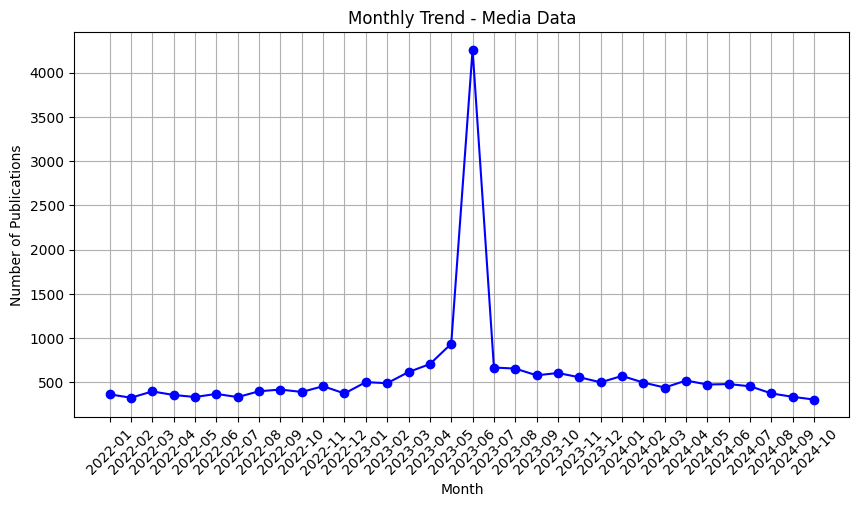

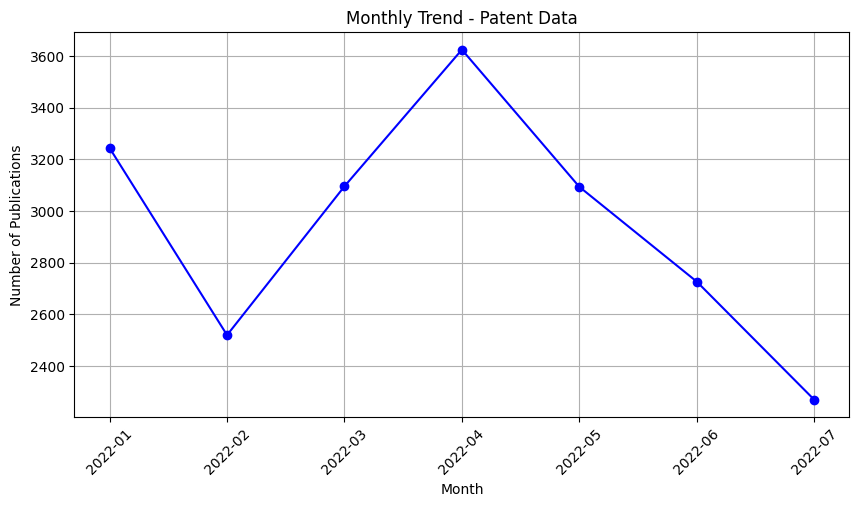

In [ ]:
# Check and convert date columns
if 'date' in processed_media_data_backup.columns:
    processed_media_data_backup['date'] = pd.to_datetime(processed_media_data_backup['date'], errors='coerce')

if 'publication_date' in processed_patent_data_backup.columns:
    processed_patent_data_backup['publication_date'] = pd.to_datetime(processed_patent_data_backup['publication_date'], errors='coerce')

# Updated function to handle different column names
def plot_monthly_trend(df, title, date_column):
    if date_column in df.columns:  # Ensure the column exists
        df['month'] = df[date_column].dt.strftime('%Y-%m')  # Format as "YYYY-MM"
        monthly_counts = df.groupby('month').size()

        plt.figure(figsize=(10, 5))
        plt.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color='blue')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
        plt.title(f'Monthly Trend - {title}')
        plt.xlabel('Month')
        plt.ylabel('Number of Publications')
        plt.grid(True)
        plt.show()
    else:
        print(f"Column '{date_column}' not found in {title} dataset.")

# Run monthly analysis with correct column names
plot_monthly_trend(processed_media_data_backup, 'Media Data', 'date')
plot_monthly_trend(processed_patent_data_backup, 'Patent Data', 'publication_date')


- different monthly trend for media data

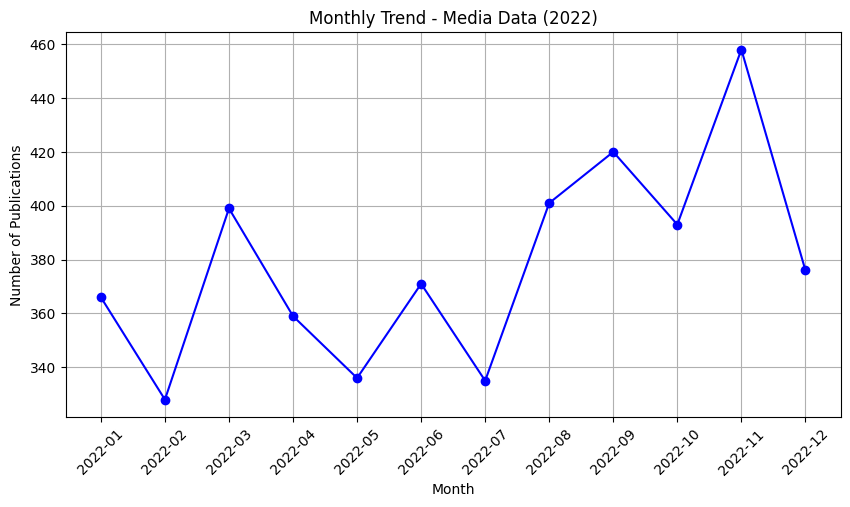

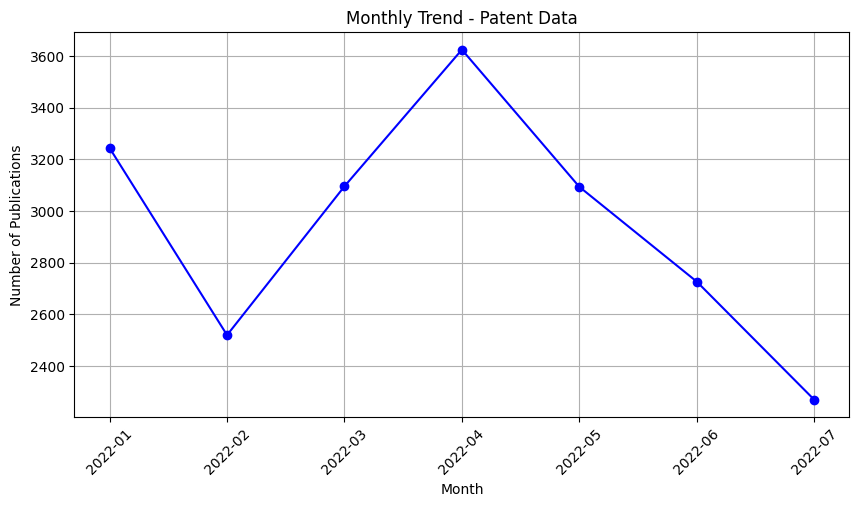

In [ ]:
# Check and convert date columns
if 'date' in processed_media_data_backup.columns:
    processed_media_data_backup['date'] = pd.to_datetime(processed_media_data_backup['date'], errors='coerce')

if 'publication_date' in processed_patent_data_backup.columns:
    processed_patent_data_backup['publication_date'] = pd.to_datetime(processed_patent_data_backup['publication_date'], errors='coerce')

# Filter media dataset for 2022 only
processed_media_data_2022 = processed_media_data_backup[
    processed_media_data_backup['date'].dt.year == 2022
]

# Updated function to handle different column names
def plot_monthly_trend(df, title, date_column):
    if date_column in df.columns:  # Ensure the column exists
        df['month'] = df[date_column].dt.strftime('%Y-%m')  # Format as "YYYY-MM"
        monthly_counts = df.groupby('month').size()

        plt.figure(figsize=(10, 5))
        plt.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color='blue')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
        plt.title(f'Monthly Trend - {title}')
        plt.xlabel('Month')
        plt.ylabel('Number of Publications')
        plt.grid(True)
        plt.show()
    else:
        print(f"Column '{date_column}' not found in {title} dataset.")

# Run monthly analysis with correct column names
plot_monthly_trend(processed_media_data_2022, 'Media Data (2022)', 'date')
plot_monthly_trend(processed_patent_data_backup, 'Patent Data', 'publication_date')


## Word Cloud Generation

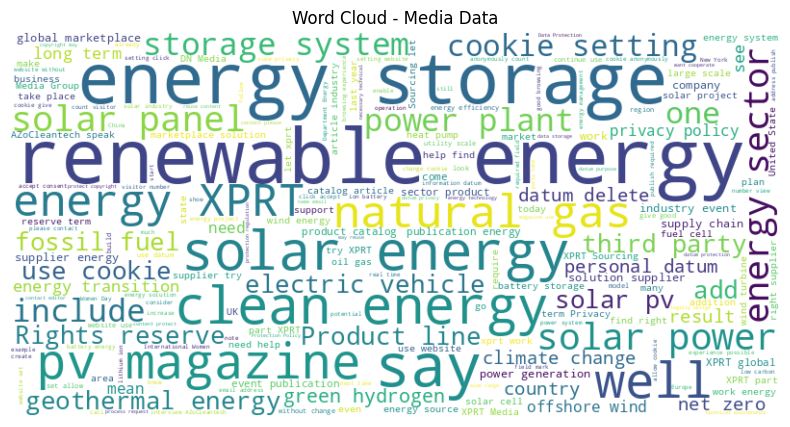

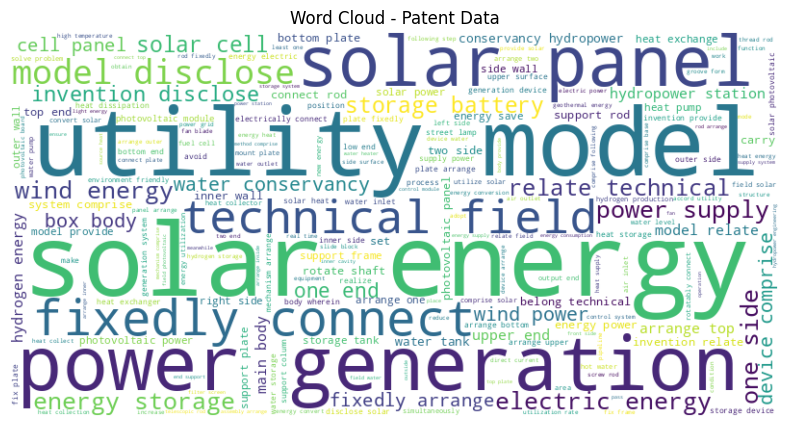

In [ ]:
# Creating word clouds to visualize frequently used words.
all_words_media = ' '.join(processed_media_data_backup['processed_text'].dropna().astype(str))
all_words_patent = ' '.join(processed_patent_data_backup['processed_text'].dropna().astype(str))

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(all_words_media, 'Word Cloud - Media Data')
generate_wordcloud(all_words_patent, 'Word Cloud - Patent Data')


## Named Entity Recognition (NER)
1. **Data Preparation**  
   - Combined two datasets (media data and patent data) after filtering out rows with missing `processed_text`.  
   - Applied a Named Entity Recognition (NER) model (spaCy) to each document to extract only **organization** and **product** entities.  

2. **Co-occurrence Matrix**  
   - For every document, we collected its unique entities (to avoid duplicating the same entity in that document).  
   - Built a co-occurrence matrix by counting how often any pair of entities appeared in the same document.  

3. **Graph Construction & Centrality**  
   - Used **cuGraph** to convert the co-occurrence data into a graph, where each entity is a node, and edges are weighted by co-occurrence count.  
   - Computed two key centrality measures:
     - **Degree Centrality**: Number of connections (co-occurrences) each entity has.  
     - **Betweenness Centrality**: How often an entity lies on the shortest paths between other nodes, acting as a "bridge."

**Interpretation of Results**

- **Top Degree Entities** like **MW**, **EV**, and **CleanTechnica** appear in many documents, making them high-degree "hubs" that co-occur frequently with other entities.  
- **Top Betweenness Entities** (e.g. **MW**, **CleanTechnica**, **SNEC**, **Solar PV**) serve as central connectors. A high betweenness suggests these terms are crucial "bridges" linking different topics or areas within the texts.

Overall, these findings highlight which entities dominate the conversation (degree) and which entities connect distinct parts of the dataset (betweenness). This insight helps pinpoint influential nodes in the network of extracted entities.


In [ ]:
print("Missing values in processed_text (Media):", processed_media_data_backup['processed_text'].isna().sum())
print("Missing values in processed_text (Patent):", processed_patent_data_backup['processed_text'].isna().sum())

# Drop rows where 'processed_text' is NaN
processed_patent_data_backup = processed_patent_data_backup.dropna(subset=['processed_text'])

Missing values in processed_text (Media): 0
Missing values in processed_text (Patent): 2239


In [ ]:
# Run takes about 6 minutes using GPU
def extract_entities(texts):
    entities_list = []
    docs = nlp.pipe(texts, disable=["parser", "tagger"])  # Performance-Optimization
    for doc in docs:
        entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT']]
        entities_list.append(entities)
    return entities_list

# Apply NER with progress bar
tqdm.pandas()
processed_media_data_backup['entities'] = extract_entities(processed_media_data_backup['processed_text'].tolist())
processed_patent_data_backup['entities'] = extract_entities(processed_patent_data_backup['processed_text'].tolist())

# Combine entitties for Co-Occurrence-Analysis
all_entities = processed_media_data_backup['entities'].tolist() + processed_patent_data_backup['entities'].tolist()


def create_cooccurrence_matrix(entities_list):
    cooccurrence = Counter()
    for entities in entities_list:
        unique_entities = list(set(entities))  # remove duplicates
        for i in range(len(unique_entities)):
            for j in range(i + 1, len(unique_entities)):
                cooccurrence[(unique_entities[i], unique_entities[j])] += 1
    return cooccurrence
cooccurrence_data = create_cooccurrence_matrix(all_entities)

In [ ]:
def cooccurrence_to_df(cooccurrence):
    """
    cooccurrence: Counter with keys=(entity1, entity2), values=co-occurrence count
    Returns a cudf.DataFrame with columns: ['entity1', 'entity2', 'weight']
    """
    edges = [(e1, e2, w) for (e1, e2), w in cooccurrence.items()]
    pdf = pd.DataFrame(edges, columns=["entity1", "entity2", "weight"])

    # 1) Ensure all entity columns are strings (or all numeric)
    pdf["entity1"] = pdf["entity1"].astype(str)
    pdf["entity2"] = pdf["entity2"].astype(str)

    # 2) Ensure weight is numeric (if you have a weight column)
    pdf["weight"] = pdf["weight"].astype(float)

    gdf = cudf.DataFrame.from_pandas(pdf)
    return gdf


def calculate_centralities_cugraph(cooccurrence, k=10):
    """
    Calculate centrality measures (degree, betweenness) using cugraph.
    Returns a dictionary with 'graph' plus each centrality measure as dict-of-node->value.
    """
    gdf = cooccurrence_to_df(cooccurrence)

    G = cugraph.Graph(directed=False)
    G.from_cudf_edgelist(
        gdf,
        source="entity1",
        destination="entity2",
        edge_attr="weight",
        renumber=True
    )

    # Compute degree & betweenness
    deg_df = G.degree()  # columns: ['vertex', 'degree']
    bc_df = cugraph.betweenness_centrality(G, k=k)  # columns: ['vertex', 'betweenness_centrality']

    # Rename 'vertex' to 'entity' so it’s clear to us
    deg_df = deg_df.rename(columns={"vertex": "entity"})
    bc_df = bc_df.rename(columns={"vertex": "entity"})

    # Convert to Python dictionaries
    deg_dict = dict(zip(deg_df["entity"].to_pandas(), deg_df["degree"].to_pandas()))
    bc_dict = dict(zip(bc_df["entity"].to_pandas(), bc_df["betweenness_centrality"].to_pandas()))

    return {
        "graph": G,
        "degree": deg_dict,
        "betweenness": bc_dict
    }

centralities_gpu = calculate_centralities_cugraph(cooccurrence_data)

print("Degree sample:", list(centralities_gpu["degree"].items())[:10])
print("Betweenness sample:", list(centralities_gpu["betweenness"].items())[:10])


Degree sample: [('GE Power Social Accounts', 252), ('InSight', 252), ('Messung Systems Pvt', 252), ('NCM Aries Grid', 252), ('Syneto', 252), ('Energy Storage Summit Park Plaza Victoria London', 250), ('Power Control Management ltd', 250), ('Directives Lot Lot', 250), ('Wörrstadt GERMANY Solar Service', 250), ('Washington State University University Tennessee', 250)]
Betweenness sample: [('GE Power Social Accounts', 4.173006978267875e-06), ('InSight', 8.06573763034485e-06), ('Messung Systems Pvt', 3.626638098677385e-06), ('NCM Aries Grid', 1.4527770392833587e-06), ('Syneto', 4.079096938541353e-07), ('Energy Storage Summit Park Plaza Victoria London', 1.105597111522803e-06), ('Power Control Management ltd', 3.4061009668225484e-06), ('Directives Lot Lot', 3.631186596473626e-06), ('Wörrstadt GERMANY Solar Service', 3.873889073393814e-05), ('Washington State University University Tennessee', 2.3028426247833363e-06)]


In [ ]:
deg_items = list(centralities_gpu["degree"].items())
bc_items = list(centralities_gpu["betweenness"].items())

# Sort by degree descending
deg_sorted = sorted(deg_items, key=lambda x: x[1], reverse=True)
# Sort by betweenness descending
bc_sorted = sorted(bc_items, key=lambda x: x[1], reverse=True)

print("Top 10 by Degree:")
for node, val in deg_sorted[:10]:
    print(node, val)

print("\nTop 10 by Betweenness:")
for node, val in bc_sorted[:10]:
    print(node, val)


Top 10 by Degree:
MW 31496
EV 24676
CleanTechnica 22002
Data Protection Policy 21910
the Cypher ES AFM Oxford Instruments Asylum Research 21710
EU 17274
GW 16584
ETH Development 14194
Adina Rom Executive 14194
Plastic Planet International Women Day 14194

Top 10 by Betweenness:
MW 0.1532668214614546
CleanTechnica 0.09388796001378495
SNEC 0.09290903189520973
Solar PV 0.0803479316231887
GW 0.07525791501924954
Data Protection Policy 0.056121005752504664
Crown Estate 0.05508622704086387
EU 0.04924596378673722
Shell 0.04129770846096697
EV 0.037674852318197886


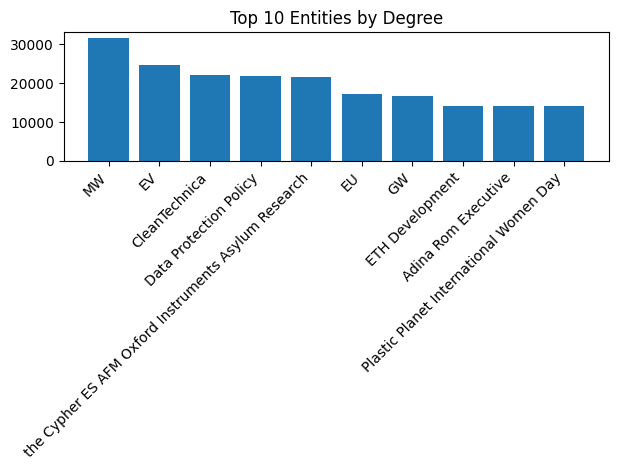

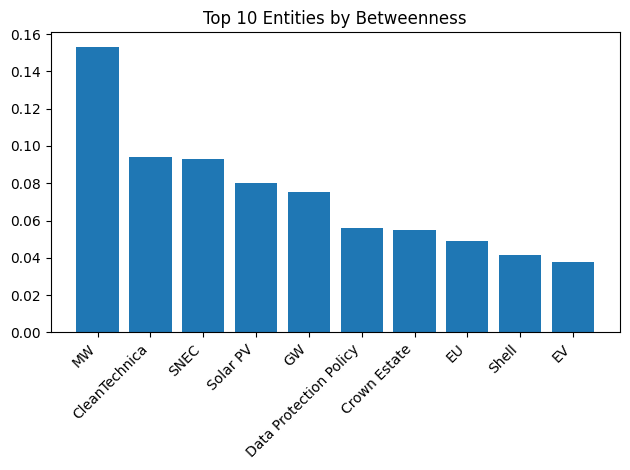

In [ ]:
top_deg = deg_sorted[:10]
top_bc = bc_sorted[:10]

# Plot Top 10 by Degree
nodes_deg, values_deg = zip(*top_deg)  # unzip (entity, degree)
plt.figure()
plt.bar(nodes_deg, values_deg)
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Entities by Degree")
plt.tight_layout()
plt.show()

# Plot Top 10 by Betweenness
nodes_bc, values_bc = zip(*top_bc)  # unzip (entity, betweenness)
plt.figure()
plt.bar(nodes_bc, values_bc)
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Entities by Betweenness")
plt.tight_layout()
plt.show()

##LAST CHECKS
Outputs:
- Notebook with data cleaning and preprocessing steps.
- Notebook with EDA visualizations on e.g. hidden topics and the detailed comparison between
the two datasets.


# Topic-Modeling
Lead: Rafaella Miranda-Sousa Wasser

In [8]:
# Load and preprocess data
documents = processed_media_data_backup['processed_text'].dropna().tolist() + \
            processed_patent_data_backup['processed_text'].dropna().tolist()

# Ensure that the directory for saving models exists
save_path = "/content/drive/MyDrive/CLT/models/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# LDA
Lead: Rafaella Miranda-Sousa Wasser

In [13]:
id2word = corpora.Dictionary([text.split() for text in documents])
corpus = [id2word.doc2bow(text.split()) for text in documents]

lda_model = LdaModel(
    corpus=corpus, id2word=id2word, num_topics=10, random_state=100,
    update_every=1, chunksize=500, passes=20, alpha='auto', per_word_topics=True
)

# Extract topics
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn=20)
        word_dict[f'Topic #{i+1:02d}'] = [word[0] for word in words]
    return pd.DataFrame(word_dict)

lda_topics_df = get_lda_topics(lda_model, 10)
print("\nLDA Topics:")
print(lda_topics_df)

# Coherence Score Evaluation
lda_coherence_model = CoherenceModel(model=lda_model, texts=[text.split() for text in documents], dictionary=id2word, coherence='c_v')
lda_coherence_score = lda_coherence_model.get_coherence()
print(f"LDA Coherence Score: {lda_coherence_score:.4f}")

# Save LDA model
lda_model.save(save_path + "lda_model.gensim")

# LDA Visualization
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(lda_vis)


LDA Topics:
      Topic #01   Topic #02    Topic #03    Topic #04     Topic #05  \
0       silicon       hinge       method         heat    geothermal   
1         datum         the          the        water         rotor   
2            pv      energy        model       energy          well   
3          cell       solar        datum         pipe          deep   
4   ultraviolet         say         time          air            de   
5           the        year         step          the          rock   
6        module        also    invention     hydrogen        convey   
7         solar      market          use       system       shallow   
8           use  investment      station        solar      drilling   
9           may    capacity    rainwater         tank   underground   
10      website      spiral        level  temperature           the   
11        wafer     project  circulation      storage        mining   
12      battery         new  information      heating         ax

# Non-Negative Matrix Factorization (NMF)
Lead: Rafaella Miranda-Sousa Wasser

In [14]:
# Create TF-IDF representation
vectorizer = CountVectorizer(analyzer='word', max_features=1000, stop_words='english')
x_counts = vectorizer.fit_transform(documents)
transformer = TfidfTransformer()
x_tfidf = transformer.fit_transform(x_counts)
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

# Train NMF model
nmf_model = NMF(n_components=10, init='nndsvd', random_state=42)
nmf_model.fit(xtfidf_norm)

# Extract NMF topics
def get_nmf_topics(model, vectorizer, num_topics=10, n_top_words=10):
    feat_names = vectorizer.get_feature_names_out()
    word_dict = {}

    for i in range(num_topics):
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        words = [re.sub(r'\S*@\S*\s?', '', sent) for sent in words]
        words = [re.sub(r'\s+', ' ', sent) for sent in words]
        words = [re.sub(r"\'", "", sent) for sent in words]
        word_dict[f'Topic #{i+1:02d}'] = words

    return pd.DataFrame(word_dict)

nmf_topics_df = get_nmf_topics(nmf_model, vectorizer)
print("\nNMF Topics:")
print(nmf_topics_df)


NMF Topics:
  Topic #01   Topic #02    Topic #03     Topic #04   Topic #05    Topic #06  \
0     plate      energy         heat        module        wind        water   
1       rod       solar   geothermal  photovoltaic       blade         pipe   
2   connect     project      heating         solar       power         tank   
3     frame   renewable          air         power   generator         pump   
4   fixedly          pv       energy         panel      energy        inlet   
5   arrange  geothermal         pump       control  generation       device   
6       fix         say         pipe        energy     turbine  conservancy   
7   support         new     exchange          cell      rotate       outlet   
8    rotate        year  temperature        supply       shaft         flow   
9       end     company    exchanger       battery   invention     hydropow   

  Topic #07   Topic #08  Topic #09 Topic #10  
0     layer    hydrogen       body      lamp  
1      cell  production

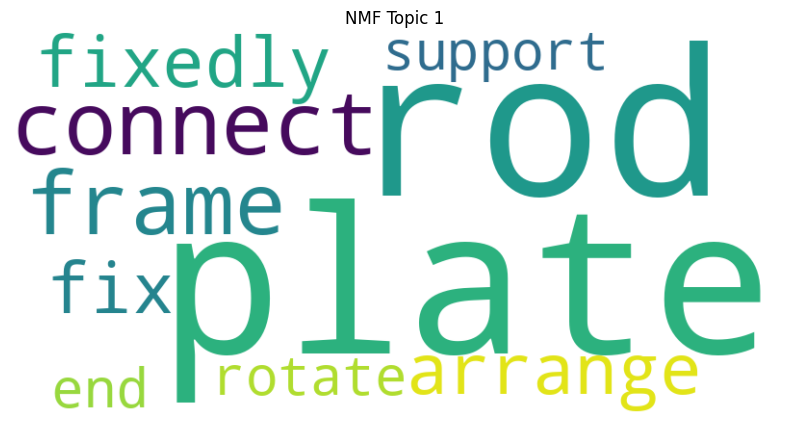

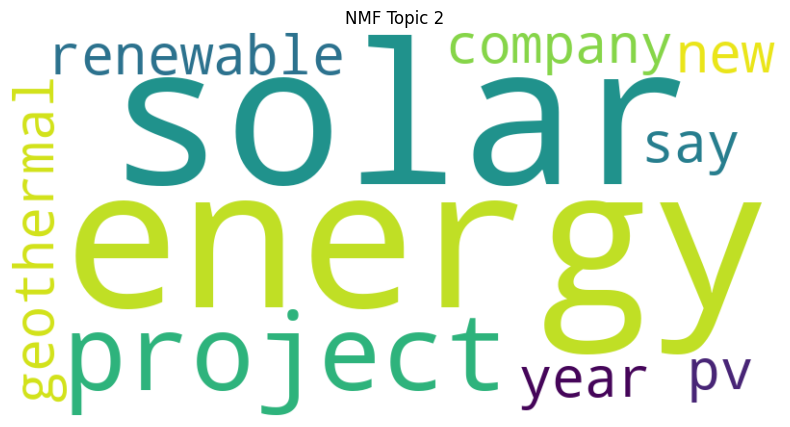

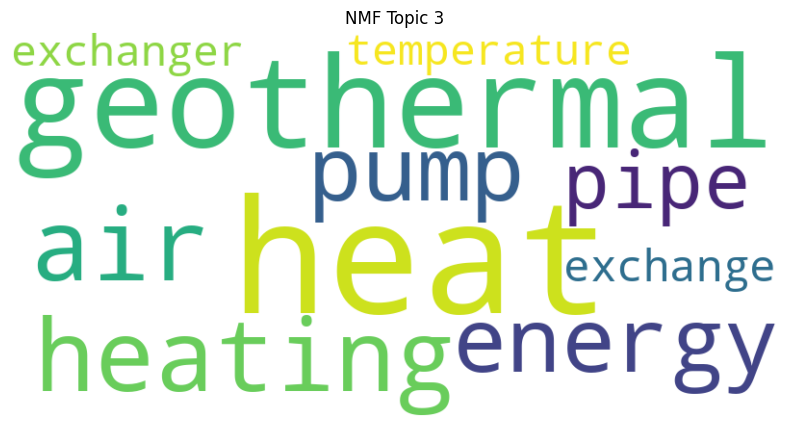

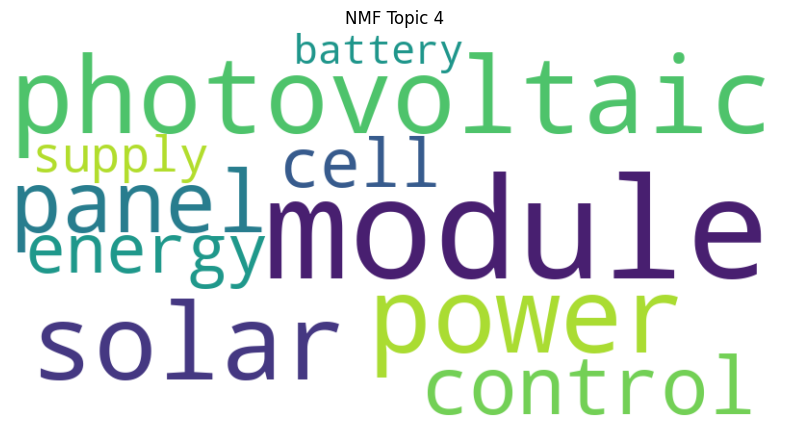

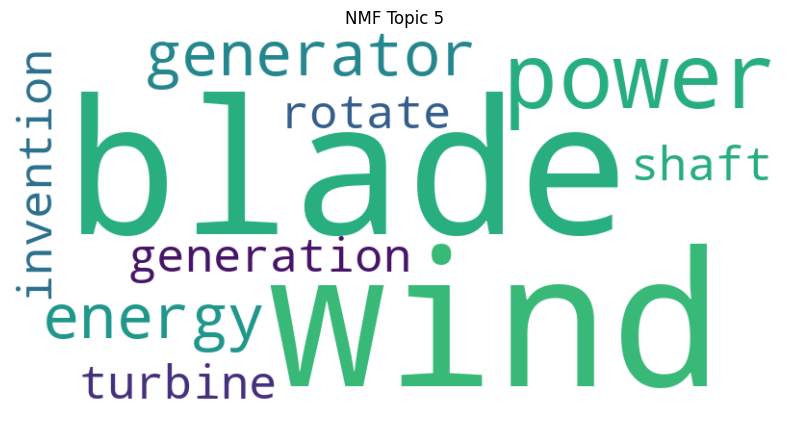

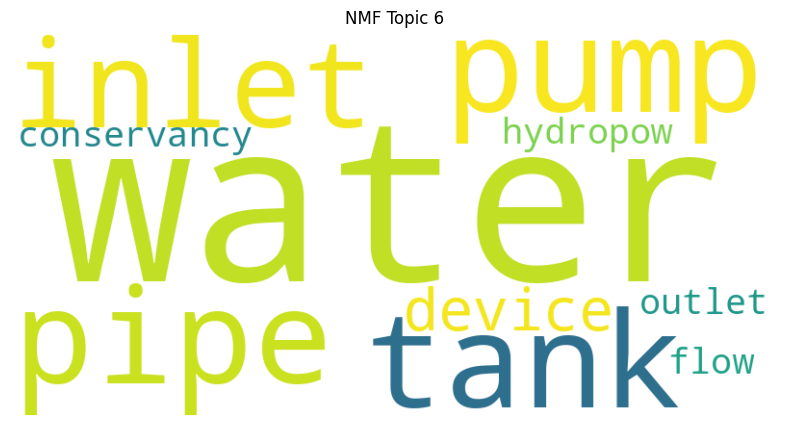

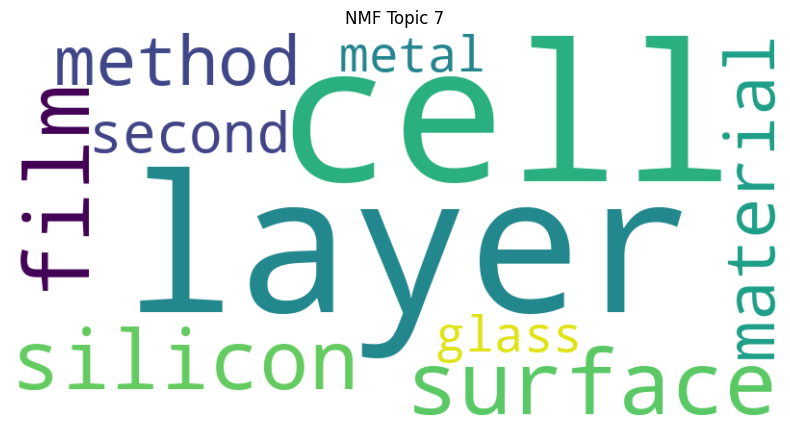

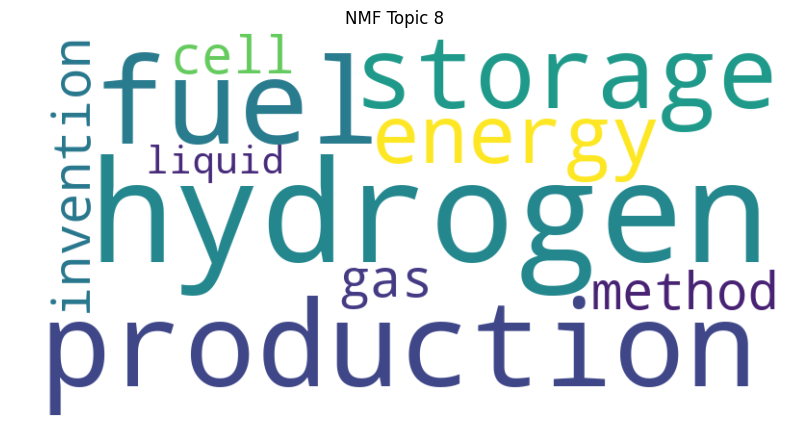

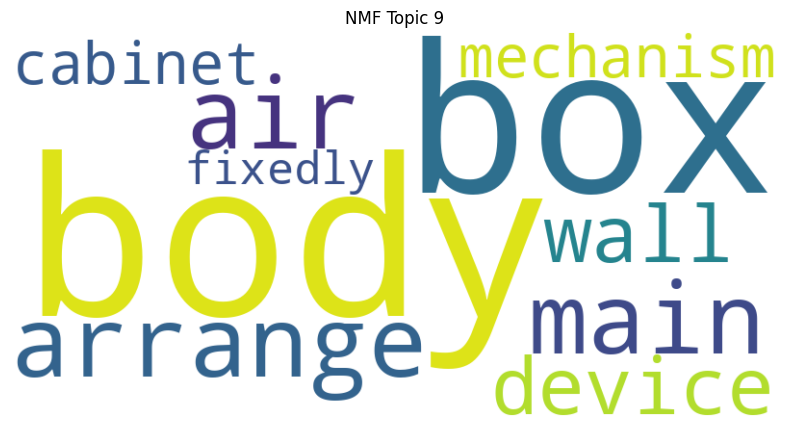

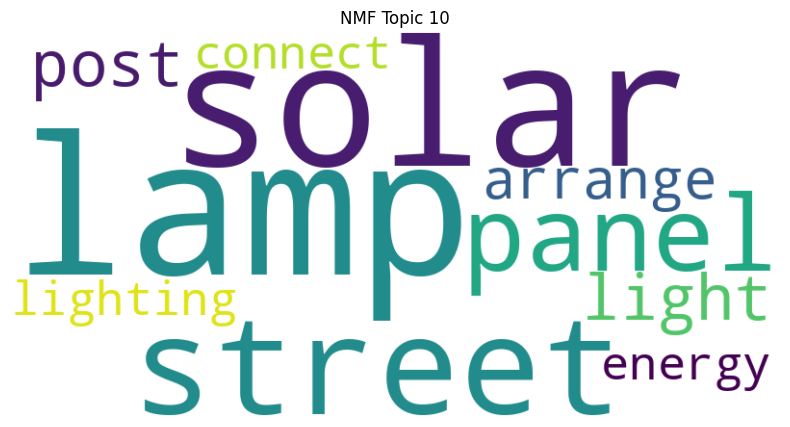

  Topic #01   Topic #02    Topic #03     Topic #04   Topic #05    Topic #06  \
0     plate      energy         heat        module        wind        water   
1       rod       solar   geothermal  photovoltaic       blade         pipe   
2   connect     project      heating         solar       power         tank   
3     frame   renewable          air         power   generator         pump   
4   fixedly          pv       energy         panel      energy        inlet   
5   arrange  geothermal         pump       control  generation       device   
6       fix         say         pipe        energy     turbine  conservancy   
7   support         new     exchange          cell      rotate       outlet   
8    rotate        year  temperature        supply       shaft         flow   
9       end     company    exchanger       battery   invention     hydropow   

  Topic #07   Topic #08  Topic #09 Topic #10  
0     layer    hydrogen       body      lamp  
1      cell  production        box  

In [15]:
# NMF Topic Visualization - WordCloud
for i in range(10):
    topic_words = nmf_topics_df[f'Topic #{i+1:02d}'].tolist()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(topic_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'NMF Topic {i+1}')
    plt.show()

# Run the code and check the extracted topics
print(nmf_topics_df)

# Test different numbers of topics or words
nmf_topics_df = get_nmf_topics(nmf_model, vectorizer, num_topics=5, n_top_words=15)

print(nmf_topics_df)

# Cosine Similarity Document Recommendation
Lead: Rafaella Miranda-Sousa Wasser

In [18]:
titles = processed_media_data_backup['title'].tolist() + processed_patent_data_backup['title'].tolist()

# Create TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(documents)

# Compute cosine similarity
def cosine_sim(text1, text2):
    tfidf_score = TfidfVectorizer().fit_transform([text1, text2])
    return ((tfidf_score * tfidf_score.T).A)[0, 1]

# Find most similar documents
def closest_doc_name(sentence, docs, num_results=10):
    query_tfidf = vectorizer.transform([sentence])
    cosine_similarities = (tfidf_matrix * query_tfidf.T).toarray().flatten()
    top_indices = np.argsort(cosine_similarities)[-num_results:][::-1]
    return [(titles[i], cosine_similarities[i]) for i in top_indices]

# Example search query
recommended_docs = closest_doc_name("renewable energy", documents)

print("\nTop recommended documents:")
for title, score in recommended_docs:
    print(f"{title} - Similarity: {score:.4f}")

# Save TF-IDF model
with open(save_path + "tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
with open(save_path + "tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)


Top recommended documents:
Unlocking the power of renewables with energy storage - Similarity: 0.6776
Debunking Myths: The Truth About Renewable Energy - Similarity: 0.6232
Creating Renewable Energy Integration Solutions - Similarity: 0.5939
Why do Renewable Energy Meters appear? - Similarity: 0.5818
Shaping The Future: Insights From IRENA's 2024 Renewable Energy Statistics Report - Similarity: 0.5394
Renewable Energy Compliance ( Renewable Energy) Articles - Similarity: 0.5227
Analyzing India's Renewable Energy Milestone: Solar Dominance Power Generation In March 2024 - Similarity: 0.5224
Solar And Wind Capture ~82% of India's Renewable Energy Generation in December 2023 - Similarity: 0.5223
Energy Mix: From Coal to Renewables - Similarity: 0.5130
Energy Assets Companies and Suppliers ( Energy Management) - Similarity: 0.5070


In [19]:
#Run the code and check the extracted topics
print(nmf_topics_df)

    Topic #01   Topic #02    Topic #03     Topic #04   Topic #05
0       plate      energy         heat        module        wind
1         rod       solar   geothermal  photovoltaic       blade
2     connect     project      heating         solar       power
3       frame   renewable          air         power   generator
4     fixedly          pv       energy         panel      energy
5     arrange  geothermal         pump       control  generation
6         fix         say         pipe        energy     turbine
7     support         new     exchange          cell      rotate
8      rotate        year  temperature        supply       shaft
9         end     company    exchanger       battery   invention
10      block     storage        solar        device         fan
11      slide     battery    collector        charge       speed
12      mount  technology      storage      electric         air
13     groove       datum       source    generation      device
14  mechanism       power

In [20]:
#Test different numbers of topics or words
nmf_topics_df = get_nmf_topics(nmf_model, vectorizer, num_topics=5, n_top_words=15)


# Test document recommendations for new search terms:
Lead: Rafaella Miranda-Sousa Wasser

In [21]:
print(closest_doc_name("solar power", documents))

[('Solar Power Generation ( Solar Energy) Downloads', 0.5293892169780542), ('Solar Power Plants ( Solar Energy) Downloads', 0.5203496467722978), ('New energy culture signboard with wind-solar complementary power supply', 0.5042586695029194), ('Solar Power Production ( Solar Energy) Videos', 0.4971726576517034), ('Solar Power Plants ( Solar Energy) Videos', 0.48616481028884173), ('Solar Power Production ( Solar Energy) Downloads', 0.4752920298520206), ('solar power generation Equipment', 0.46719648596824714), ('一种太阳能储能装置', 0.4638176679546662), ('Power line monitoring devices based on image vision', 0.4638176679546662), ('Solar Power Generation ( Solar Energy) Videos', 0.4591208056445965)]


# Interpret NMF topics:
Lead: Rafaella Miranda-Sousa Wasser


In [22]:
print(nmf_topics_df)

            Topic #01        Topic #02        Topic #03   Topic #04  \
0         caterpillar              ash               bc        bulb   
1             closely           commit        balancing        cash   
2          allocation        certified            beach      commit   
3               axial      circulation         accident        cell   
4          automotive     characterize              ash      carbon   
5             acquire        balancing          channel   ambitious   
6          automobile        coalition          catalog         ash   
7         composition              byd       atmosphere   aesthetic   
8              clothe         continue    concentration   composite   
9              ascent             alfa      atmospheric     adapter   
10              adina  competitiveness           commit  applicable   
11  commercialization          adapter          airflow     african   
12           buoyancy      concentrate  competitiveness        army   
13    

# BERTopic
Lead: Rafaella Miranda-Sousa Wasser

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import torch

# 1. Check if a GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 2. Ensure 'documents' is correctly initialized
documents = processed_media_data_backup['processed_text'].dropna().tolist() + \
            processed_patent_data_backup['processed_text'].dropna().tolist()

# 3. Load a faster embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# 4. Initialize BERTopic with GPU-compatible settings
bertopic_model = BERTopic(
    embedding_model=embedding_model,
    calculate_probabilities=True,
    verbose=True
)

# 5. Perform topic modeling
try:
    bertopic_topics, probs = bertopic_model.fit_transform(documents)
    print("BERTopic modeling successful!")
except Exception as e:
    print(f"Error during BERTopic modeling: {e}")

# 6. Save the model
bertopic_model.save("/content/drive/MyDrive/CLT/models/bertopic_model")

# 7. Visualizations
bertopic_model.visualize_barchart()
bertopic_model.visualize_topics()
bertopic_model.visualize_heatmap()


Using device: cuda


2025-03-13 20:15:39,718 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1272 [00:00<?, ?it/s]

2025-03-13 20:17:44,051 - BERTopic - Embedding - Completed ✓
2025-03-13 20:17:44,052 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-13 20:18:43,837 - BERTopic - Dimensionality - Completed ✓
2025-03-13 20:18:43,844 - BERTopic - Cluster - Start clustering the reduced embeddings


In [ ]:
# Get all topics
topics = bertopic_model.get_topics()

# Ensure topics were generated
if topics and isinstance(topics, dict) and len(topics) > 0:
    print(f"Number of topics found: {len(topics)}")

    # Save and display BERTopic visualizations
    display(bertopic_model.visualize_barchart())
    bertopic_model.visualize_barchart().write_html(os.path.join(save_path, "bertopic_barchart.html"))

    display(bertopic_model.visualize_topics())
    bertopic_model.visualize_topics().write_html(os.path.join(save_path, "bertopic_topics.html"))

    display(bertopic_model.visualize_heatmap())
    bertopic_model.visualize_heatmap().write_html(os.path.join(save_path, "bertopic_heatmap.html"))

    print("BERTopic visualizations saved")
else:
    print("No topics were found by BERTopic. Skipping visualization.")


Number of topics found: 278


TypeError: 'bool' object is not iterable

In [ ]:
bertopic_model = BERTopic(verbose=True)
bertopic_topics, probs = bertopic_model.fit_transform(documents)

print("\nBERTopic Topics Overview:")
print(bertopic_model.get_topic_info())

# Evaluate BERTopic coherence using C_v score
bertopic_coherence_model = CoherenceModel(topics=[bertopic_model.get_topic(i) for i in range(len(bertopic_model.get_topics()))],
                                          texts=texts, dictionary=id2word, coherence='c_v')
bertopic_coherence_score = bertopic_coherence_model.get_coherence()
print(f"BERTopic Coherence Score: {bertopic_coherence_score:.4f}")

# Save BERTopic model
bertopic_model.save(save_path + "bertopic_model")

# Visualizations
bertopic_model.visualize_barchart()
bertopic_model.visualize_topics()
bertopic_model.visualize_heatmap()

2025-03-13 14:13:16,841 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1272 [00:00<?, ?it/s]

2025-03-13 14:15:31,244 - BERTopic - Embedding - Completed ✓
2025-03-13 14:15:31,245 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-13 14:16:34,267 - BERTopic - Dimensionality - Completed ✓
2025-03-13 14:16:34,270 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-13 14:16:40,759 - BERTopic - Cluster - Completed ✓
2025-03-13 14:16:40,777 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-13 14:16:56,784 - BERTopic - Representation - Completed ✓



BERTopic Topics Overview:
     Topic  Count                                         Name  \
0       -1  14188          -1_energy_technology_solution_power   
1        0    487        0_hydrogen_green_electrolysis_ammonia   
2        1    373        1_australia_australian_queensland_rez   
3        2    345                 2_blade_shaft_generator_wind   
4        3    336                        3_tesla_car_ford_zach   
..     ...    ...                                          ...   
758    757     10        757_charge_gooseneck_interaction_text   
759    758     10  758_recurrent_blackrock_brightsource_mannum   
760    759     10      759_sungrow_midsummer_inverter_herholdt   
761    760     10                760_lithium_ion_battery_anode   
762    761     10               761_valve_floater_pipe_exhaust   

                                        Representation  \
0    [energy, technology, solution, power, system, ...   
1    [hydrogen, green, electrolysis, ammonia, elect...   
2    [

NameError: name 'CoherenceModel' is not defined

# Experimentelle Alternative: BERTopic (LLM)
Lead: Rafaella Miranda-Sousa Wasser

In [ ]:
!pip install llama-cpp-python bertopic datasets sentence-transformers cuml-cu12 dask-cudf-cu12 cugraph-cu12 cupy-cuda12x datamapplot


In [ ]:
# Load Your Own Data
from datasets import load_dataset

# Use your Cleantech dataset instead of ArXiv
documents = processed_media_data_backup['processed_text'].dropna().tolist() + \
            processed_patent_data_backup['processed_text'].dropna().tolist()


In [ ]:
# Use a LLM to Label Topics
from llama_cpp import Llama

# Load a quantized Llama model for automatic topic labeling
llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"])



In [ ]:
#Create an Improved Representation Model
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}


In [ ]:
# Compute Embeddings Efficiently
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP

embedding_model = SentenceTransformer("BAAI/bge-small-en")

# Compute document embeddings
embeddings = embedding_model.encode(documents, show_progress_bar=True)

# Pre-reduce embeddings for visualization
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)


# Experiment Define Clustering & Topic Modeling Pipeline
Uses UMAP for dimensionality reduction.
Uses HDBSCAN for topic clustering.
Integrates the LLM for topic labeling.

Lead: Rafaella Miranda-Sousa Wasser

In [ ]:
from cuml.cluster import HDBSCAN
from bertopic import BERTopic

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=400, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  top_n_words=10,
  verbose=True
)

# Train the BERTopic model
topics, probs = topic_model.fit_transform(documents, embeddings)

# Show topic summary
print(topic_model.get_topic_info())


In [ ]:
# Generate a DataMap Visualization
import datamapplot
import re
import numpy as np
import requests
import PIL

# Prepare logo for visualization
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

# Extract labels for visualization
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Generate interactive plot
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="BERTopic - Cleantech Dataset",
    sub_title="Topics labeled with Llama.cpp",
    label_wrap_width=20,
    use_medoids=True,
    logo=bertopic_logo,
    logo_width=0.16
)


# ALVARO

#  Top2Vec
Lead: Alvaro Cervan

In [ ]:
top2vec_model = Top2Vec(documents, embedding_model="universal-sentence-encoder")

print("\nTop2Vec Topic Overview:")
print(top2vec_model.get_topics())

# Save Top2Vec model
top2vec_model.save(save_path + "top2vec_model")

# Evaluate Top2Vec coherence
top2vec_topics, _ = top2vec_model.get_topics()
top2vec_coherence_model = CoherenceModel(topics=top2vec_topics, texts=texts, dictionary=id2word, coherence='c_v')
top2vec_coherence_score = top2vec_coherence_model.get_coherence()
print(f"Top2Vec Coherence Score: {top2vec_coherence_score:.4f}")

# Evaluation
Lead: Alvaro Cervan

In [ ]:
print(f"LDA Coherence: {lda_coherence_score}")
print(f"NMF Coherence: {nmf_coherence_score}")
print(f"BERTopic Coherence: {bertopic_coherence_score}")
print(f"Top2Vec Coherence: {top2vec_coherence_score}")


In [ ]:
print(closest_doc_name("solar power", documents))


# Hierarchical topic modeling
Lead: Alvaro Cervan

# Visualize and interpret
Lead: Alvaro Cervan

Visualize and interpret the topics, comparing emerging trends in media publications against
focuses of recent patents.